In [115]:
import requests
from bs4 import BeautifulSoup
import io
import pandas as pd

# url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3740566.txt?1624879808?v=1625562924528'
url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3816281.txt?rv3jop'
headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 "
                         "Safari/537.36"}

file = open("qs-rank.txt", "w")

path = '/Users/niloy/Desktop/Win10/CodeRepository/Find-Professor-CSRanking/qs-rank.txt'


def get_page(url):
    try:
        r = requests.get(url, headers=headers)
        if r.status_code == 200:
            return r.json()
    except requests.ConnectionError as e:
        print(e)


def parser_page(json):
    if json:
        items = json.get('data')
        for i in range(len(items)):
            item = items[i]
            qsrank = {}
            qsrank['core_id'] = item['core_id']
            if "=" in item['rank_display']:
                rk_str = str(item['rank_display']).split('=')[-1]
                qsrank['rank_display'] = rk_str
            else:
                qsrank['rank_display'] = item['rank_display']
            qsrank['title'] = BeautifulSoup(item['title'], "html.parser").text
            qsrank['country'] = item['country']
            qsrank['city'] = item['city']
            qsrank['region'] = item['region']
            qsrank['score'] = item['score']
            qsrank['logo'] = item['logo']



            yield qsrank


def main():
    json = get_page(url)
    results = parser_page(json)
    for result in results:
        with io.open(path, 'a', encoding="utf-8") as f:
            f.write(result['core_id'] + ';' + result['rank_display'] + ';' + result['title'] + ';' + result['country'] + ';' + result['city'] + ';' + result['region'] + ';' + result['score'] + ';' + 'https://www.topuniversities.com' + result['logo'] + '\n')  # df['Logo'] = '=IMAGE("' + df['logo'] + '")'
            f.close()
            # print(result)


if __name__ == '__main__':
    print('Started parsing！')
    with io.open(path, 'a', encoding="utf-8") as f:
        f.write('Core_id' + ';' + 'Ranking' + ';' + 'University' + ';' + 'Country' + ';' + 'City' + ';' + 'Region' + ';' + 'Score' + ';' +'logo' + '\n')
        f.close()
    main()

    df = pd.read_csv('qs-rank.txt', delimiter=';', header=0)
    df.to_csv('qs-rank.csv', index=False)

    print('Done & Convered to CSV')

Started parsing！
Done & Convered to CSV


# Upload to Google Sheet

Sheet Link: 
https://docs.google.com/spreadsheets/d/1uThYmBCT17XTeRJBffZ3ddLSM1DNtZnOliMIB_nDvVM/edit#gid=1038230137

In [3]:
import gspread 
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
# from mysql import connector

In [4]:
scope= ['https://spreadsheets.google.com/feeds']
creds = ServiceAccountCredentials.from_json_keyfile_name('our-sign-312610-36119a9d9e84.json', scope)
client = gspread.authorize(creds)

In [5]:
sheet_ID= '1uThYmBCT17XTeRJBffZ3ddLSM1DNtZnOliMIB_nDvVM'
sheet = client.open_by_key(sheet_ID).get_worksheet(2)


### Make a Column for Google Sheet that visualize the logo

In [87]:

df['Image'] = chr(df.columns.get_loc('logo') + 65) + (df.index + 1).astype(str)
df['Image'] = '=' + df['Image'].apply(lambda x: f"IMAGE({x})")
df

,Core_id,Ranking,University,Country,City,Region,Score,logo,Image
0,410,1,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,100.0,https://www.topuniversities.com/sites/default/...,=IMAGE(H1)
1,95,2,University of Cambridge,United Kingdom,Cambridge,Europe,98.8,https://www.topuniversities.com/sites/default/...,=IMAGE(H2)
2,573,3,Stanford University,United States,Stanford,North America,98.5,https://www.topuniversities.com/sites/default/...,=IMAGE(H3)
3,478,4,University of Oxford,United Kingdom,Oxford,Europe,98.4,https://www.topuniversities.com/sites/default/...,=IMAGE(H4)
4,253,5,Harvard University,United States,Cambridge,North America,97.6,https://www.topuniversities.com/sites/default/...,=IMAGE(H5)
...,...,...,...,...,...,...,...,...,...
1417,2291,1401+,Universidad Tecnológica de Bolívar,Colombia,Cartagena,Latin America,NaN,https://www.topuniversities.com/sites/default/...,=IMAGE(H1418)
1418,1708,1401+,Universidad de Tarapaca,Chile,Arica,Latin America,NaN,https://www.topuniversities.com/sites/default/...,=IMAGE(H1419)
1419,1491,1401+,University of Craiova,Romania,Craiova,Europe,NaN,https://www.topuniversities.com/sites/default/...,=IMAGE(H1420)
1420,14118,1401+,University of Oradea,Romania,Oradea,Europe,NaN,https://www.topuniversities.com/sites/default/...,=IMAGE(H1421)


In [88]:
# Clear existing data in the sheet
sheet.clear()


# Get the column names as a list
column_names = df.columns.tolist()

# Insert the column names as the first row in the Google Sheet
sheet.insert_row(column_names, index=1)

# Convert the DataFrame to a list of lists (excluding the column names)
df = df.astype(str)
data = df.values.tolist()

# Update the sheet with the new data
# sheet.append_rows(data)

sheet.append_rows(data, value_input_option='USER_ENTERED')

{'spreadsheetId': '1uThYmBCT17XTeRJBffZ3ddLSM1DNtZnOliMIB_nDvVM',
 'tableRange': 'List!A1:I1',
 'updates': {'spreadsheetId': '1uThYmBCT17XTeRJBffZ3ddLSM1DNtZnOliMIB_nDvVM',
  'updatedRange': 'List!A2:I1423',
  'updatedRows': 1422,
  'updatedColumns': 9,
  'updatedCells': 12798}}

In [89]:
new_data = sheet.get_all_records()
new_df = pd.DataFrame(new_data)
new_df

,Core_id,Ranking,University,Country,City,Region,Score,logo,Image
0,410,1,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,100.0,https://www.topuniversities.com/sites/default/...,
1,95,2,University of Cambridge,United Kingdom,Cambridge,Europe,98.8,https://www.topuniversities.com/sites/default/...,
2,573,3,Stanford University,United States,Stanford,North America,98.5,https://www.topuniversities.com/sites/default/...,
3,478,4,University of Oxford,United Kingdom,Oxford,Europe,98.4,https://www.topuniversities.com/sites/default/...,
4,253,5,Harvard University,United States,Cambridge,North America,97.6,https://www.topuniversities.com/sites/default/...,
...,...,...,...,...,...,...,...,...,...
1417,2291,1401+,Universidad Tecnológica de Bolívar,Colombia,Cartagena,Latin America,NaN,https://www.topuniversities.com/sites/default/...,
1418,1708,1401+,Universidad de Tarapaca,Chile,Arica,Latin America,NaN,https://www.topuniversities.com/sites/default/...,
1419,1491,1401+,University of Craiova,Romania,Craiova,Europe,NaN,https://www.topuniversities.com/sites/default/...,
1420,14118,1401+,University of Oradea,Romania,Oradea,Europe,NaN,https://www.topuniversities.com/sites/default/...,


In [90]:
df

,Core_id,Ranking,University,Country,City,Region,Score,logo,Image
0,410,1,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,100.0,https://www.topuniversities.com/sites/default/...,=IMAGE(H1)
1,95,2,University of Cambridge,United Kingdom,Cambridge,Europe,98.8,https://www.topuniversities.com/sites/default/...,=IMAGE(H2)
2,573,3,Stanford University,United States,Stanford,North America,98.5,https://www.topuniversities.com/sites/default/...,=IMAGE(H3)
3,478,4,University of Oxford,United Kingdom,Oxford,Europe,98.4,https://www.topuniversities.com/sites/default/...,=IMAGE(H4)
4,253,5,Harvard University,United States,Cambridge,North America,97.6,https://www.topuniversities.com/sites/default/...,=IMAGE(H5)
...,...,...,...,...,...,...,...,...,...
1417,2291,1401+,Universidad Tecnológica de Bolívar,Colombia,Cartagena,Latin America,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1418)
1418,1708,1401+,Universidad de Tarapaca,Chile,Arica,Latin America,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1419)
1419,1491,1401+,University of Craiova,Romania,Craiova,Europe,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1420)
1420,14118,1401+,University of Oradea,Romania,Oradea,Europe,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1421)


In [91]:
df['rank'] = df['Score'].rank(ascending=False)
df

,Core_id,Ranking,University,Country,City,Region,Score,logo,Image,rank
0,410,1,Massachusetts Institute of Technology (MIT),United States,Cambridge,North America,100.0,https://www.topuniversities.com/sites/default/...,=IMAGE(H1),1422.0
1,95,2,University of Cambridge,United Kingdom,Cambridge,Europe,98.8,https://www.topuniversities.com/sites/default/...,=IMAGE(H2),923.0
2,573,3,Stanford University,United States,Stanford,North America,98.5,https://www.topuniversities.com/sites/default/...,=IMAGE(H3),924.0
3,478,4,University of Oxford,United Kingdom,Oxford,Europe,98.4,https://www.topuniversities.com/sites/default/...,=IMAGE(H4),925.0
4,253,5,Harvard University,United States,Cambridge,North America,97.6,https://www.topuniversities.com/sites/default/...,=IMAGE(H5),926.0
...,...,...,...,...,...,...,...,...,...,...
1417,2291,1401+,Universidad Tecnológica de Bolívar,Colombia,Cartagena,Latin America,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1418),461.5
1418,1708,1401+,Universidad de Tarapaca,Chile,Arica,Latin America,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1419),461.5
1419,1491,1401+,University of Craiova,Romania,Craiova,Europe,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1420),461.5
1420,14118,1401+,University of Oradea,Romania,Oradea,Europe,nan,https://www.topuniversities.com/sites/default/...,=IMAGE(H1421),461.5


In [98]:
import matplotlib.pyplot as plt
import numpy as np
def visualise_qs_ranking(df, top_ranking, num):
    """
    df: dataframe
    top_ranking: top # of universities to be selected
    num: # of countries to be visaulised
    """
    plt.style.use('seaborn-paper')
    top = df.iloc[0:top_ranking]
    
    ax = (top['Country'].value_counts().head(num).plot(
        kind='barh', 
        figsize=(20, 10), 
        color="tab:blue", 
        title="Number of Top {} Universities in QS Ranking".format(len(top['Country']))))
    ax.set_xticks(np.arange(0, top['Country'].value_counts()[0]+2, 1))

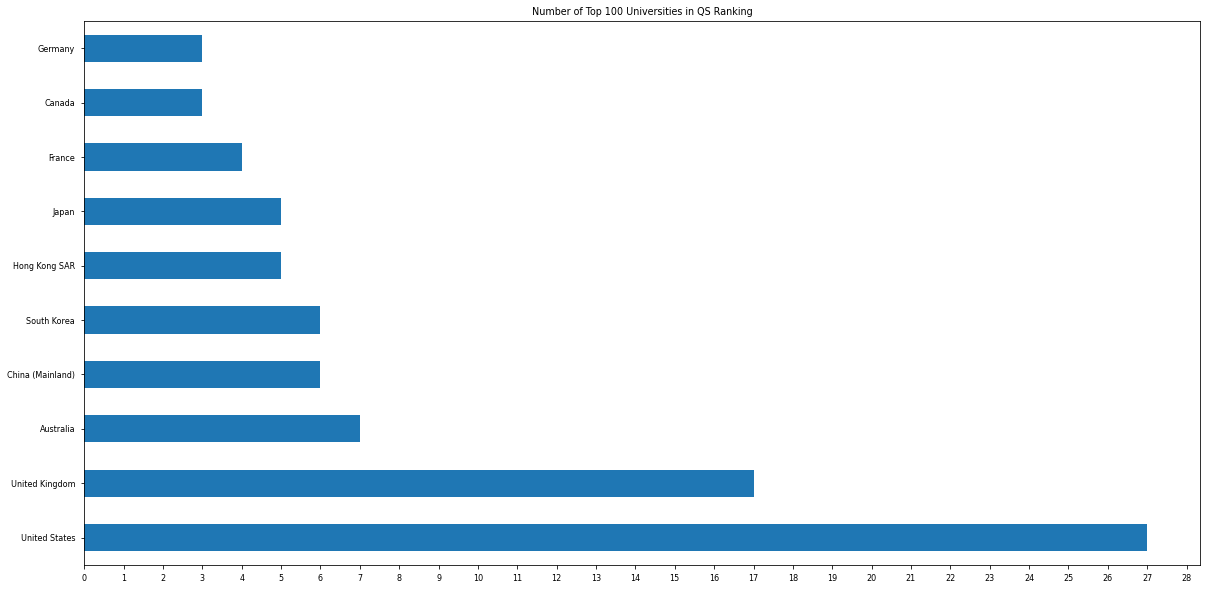

In [104]:
visualise_qs_ranking(df, top_ranking=100, num=10)

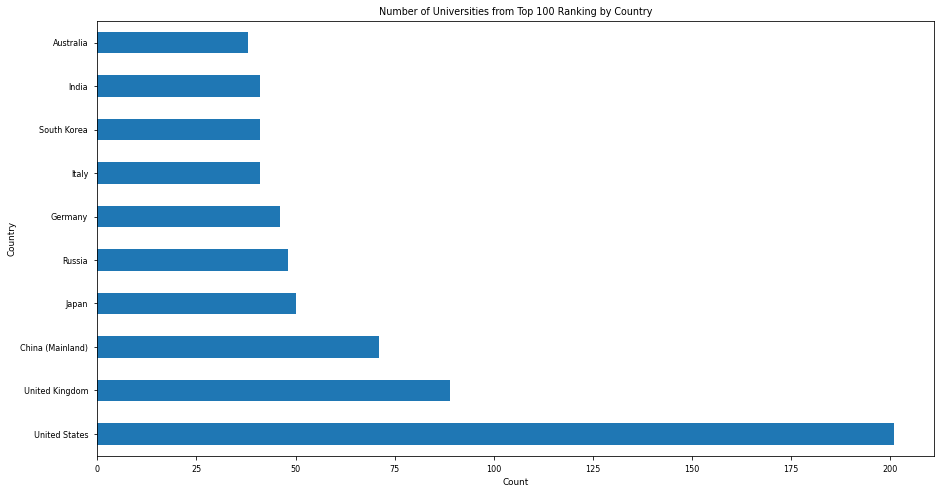

In [111]:
# Count the number of universities in each country
country_counts = df['Country'].value_counts().head(10)

# Create a vertical bar plot
plt.figure(figsize=(15, 8))
country_counts.plot(kind='barh')
plt.title('Number of Universities from Top 100 Ranking by Country')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

In [ ]:
df[(df["Country"] == "United States") & (df["Ranking"] <= 100)]